In [1]:
import nibabel as nib
import numpy as np

from dmipy.core.acquisition_scheme import acquisition_scheme_from_bvalues
from dmipy.signal_models import cylinder_models, gaussian_models
from dmipy.core.modeling_framework import MultiCompartmentModel

import matplotlib.pyplot as plt

import config
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as utils
from tqdm import tqdm

import process_data

## Trainig data

In [3]:
normalized_scan_100206 = np.load('normalised_data/normalized_scan_100206.npy')

In [4]:
normalized_scan_100206.shape

(935442, 288)

In [23]:
scan_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/data.nii.gz')

In [24]:
mask_100206 = process_data.get_nifti_data(config.data_folder2 + '/100206/nodif_brain_mask.nii.gz')

In [25]:
scan_dimension = scan_100206.shape
x = scan_dimension[0]
y = scan_dimension[1]
z = scan_dimension[2]
b = scan_dimension[3]

In [26]:
scan_100206_long = np.reshape(scan_100206, (x*y*z, b))

mask_100206_long = np.reshape(mask_100206, (x*y*z, 1))

In [27]:
# Error voxels
indices_beginning_0_all = np.where(scan_100206_long[:, 0] == 0)[0]

In [28]:
len(indices_beginning_0_all)

2234299

In [29]:
mask_0 = np.where(mask_100206_long[:,0] == 0)[0]

In [30]:
len(mask_0)

2722094

In [31]:
mask_100206_long_pro = np.copy(mask_100206_long)

In [32]:
mask_100206_long_pro[indices_beginning_0_all] = 0

In [33]:
mask_0_pro = np.where(mask_100206_long_pro[:,0] == 0)[0]
print(len(mask_0_pro))

2722908


In [34]:
scan_100206_long_no_background = process_data.remove_background(scan_100206_long, mask_100206_long_pro)

In [35]:
bvals = np.loadtxt(config.data_folder2 + '/100206/bvals') * 1e-3

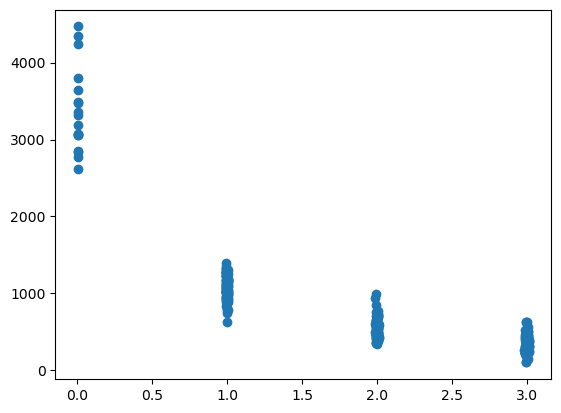

In [36]:
plt.plot(bvals, scan_100206_long_no_background[1400,:], "o")

In [37]:
scan_100206_long_no_background.shape

(935442, 288)

In [78]:
big_b_indices = np.where(bvals != 0.005)[0]
# print(big_b_indices)


(270,)


In [81]:
scan_100206_long_no_bg = np.copy(scan_100206_long_no_background)

In [ ]:
scan_100206_long_no_bg = scan_100206_long_no_bg[:, big_b_indices]

In [28]:
S0_100206 = process_data.get_S0(scan_100206_long_no_background, bvals)

In [29]:
S0_100206.shape

(935442, 1)

In [30]:
normalized_scan_100206 = scan_100206_long_no_background / S0_100206

In [71]:
len(normalized_scan_100206)

935442

In [44]:
np.save('normalized_scan_100206.npy', normalized_scan_100206)

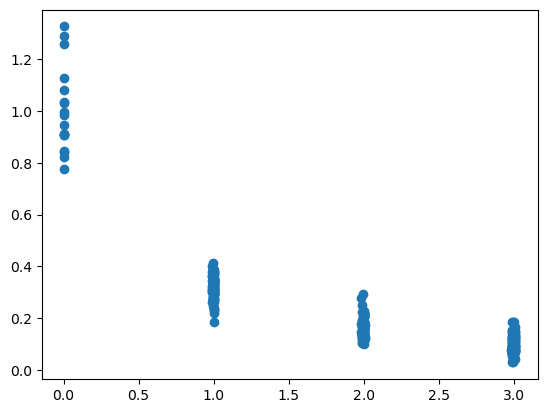

In [53]:
plt.plot(bvals, normalized_scan_100206[1400,:], "o")

## Neural Network

In [38]:
def squash(param, p_min, p_max):
    squashed_param_tensor =torch.clamp(param, min=p_min, max=p_max)
    unsqueezed_param = squashed_param_tensor.unsqueeze(1)
    return unsqueezed_param

In [39]:
def unitsphere2cart(theta, phi, X):
    mu_cart = torch.zeros(3,X.size()[0])
    sintheta = torch.sin(theta)
    mu_cart[0,:] = torch.squeeze(sintheta * torch.cos(phi))
    mu_cart[1,:] = torch.squeeze(sintheta * torch.sin(phi))
    mu_cart[2,:] = torch.squeeze(torch.cos(theta))
    return mu_cart

In [40]:
def get_acquisition_scheme():
    bvals = np.loadtxt(
        config.data_folder2 + '/100206/bvals'
    ) * 1e-3
    # s/m^2
    gradient_directions = np.loadtxt(
        config.data_folder2 + '/100206/bvecs'
    ).T

    delta = 0.0106
    Delta = 0.0431
    return acquisition_scheme_from_bvalues(bvals, gradient_directions, delta, Delta)

In [41]:
class BallStickNet(nn.Module):
    
    def __init__(self, gradient_directions, b_values):
        super(BallStickNet, self).__init__()
        self.gradient_directions = gradient_directions
        self.b_values = b_values
        self.fc_layers = nn.ModuleList()
        for i in range(3): 
            self.fc_layers.extend([nn.Linear(len(b_values), len(b_values)), nn.ELU()])
        self.encoder = nn.Sequential(*self.fc_layers, nn.Linear(len(b_values), 6))
        # if args.dropout != 0:
        #     self.dropout = nn.Dropout(args.dropout)
            
    def forward(self, X):
        # if args.dropout != 0:
        #     X = self.dropout(X)
        params = torch.abs(self.encoder(X))
        theta_uns = params[:, 0]
        theta = theta_uns.unsqueeze(1)
        phi_uns = params[:, 1]
        phi = phi_uns.unsqueeze(1)
        mu_cart = unitsphere2cart(theta, phi, X)
        mm_prod =  torch.einsum("ij,jk->ki",self.gradient_directions, mu_cart)
        lambda_par_uns = params[:, 2]
        lambda_par = squash(lambda_par_uns, 0.1, 3.0)
        lambda_iso_uns = params[:, 3]
        lambda_iso = squash(lambda_iso_uns, 0.1, 3.0)
        volume_0_uns = params[:, 4]
        volume_0 = squash(volume_0_uns, 0.01, 0.99)
        volume_1 = 1-volume_0
        s0 = params[:, 5].unsqueeze(1)
        X = s0*(volume_0 * torch.exp(-self.b_values * lambda_par * mm_prod ** 2) + volume_1 * torch.exp(-self.b_values * lambda_iso))
        return X, mu_cart, lambda_par, lambda_iso, volume_0, volume_1, s0

In [48]:
n = np.loadtxt(config.data_folder2 + '/100206/bvecs').T
b_values = torch.FloatTensor(bvals)
gradient_directions = torch.FloatTensor(n)

net = BallStickNet(gradient_directions, b_values)

In [49]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001)

In [50]:
batch_size = 128
num_batches = len(scan_100206_long_no_background) // batch_size
trainloader = utils.DataLoader(torch.from_numpy(scan_100206_long_no_background.astype(np.float32)),
                               batch_size = batch_size, 
                               shuffle = True,
                               num_workers = 2,
                               drop_last = True)

In [51]:
loss_arr=[]
avg_loss_arr=[]

counter = 0

# Best loss
best = 1e16
num_bad_epochs = 0
patience = 10

for epoch in range(1000):
    print("-----------------------------------------------------------------")
    print("Epoch: {}; Bad epochs: {}".format(epoch, num_bad_epochs))
    net.train()
    running_loss = 0.

    for i, X_batch in enumerate(tqdm(trainloader), 0):
        optimizer.zero_grad()
        X_pred, mu_cart_pred, lambda_par_pred, lambda_iso_pred,  volume_0_pred, volume_1_pred, s0_pred = net(X_batch)
        if i == 100 and counter == 10:
            print("X_batch: ")
            print(X_batch.shape)
            print(X_batch)
            print("X_pred: ")
            print(X_pred.shape)
            print(X_pred)
            print("s0_pred:")
            print(s0_pred.shape)
            print(s0_pred)
        loss = criterion(X_pred.type(torch.FloatTensor), X_batch.type(torch.FloatTensor))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
    loss_arr.append(running_loss)
    avg_loss_arr.append(running_loss/num_batches)
    print("Loss: {}".format(running_loss))
    print("Average Loss: {}".format(running_loss/num_batches))
    

    if running_loss < best:
        print("############### Saving good model ###############################")
        final_model = net.state_dict()
        best = running_loss
        num_bad_epochs = 0
    else:
        num_bad_epochs = num_bad_epochs + 1
        if num_bad_epochs == patience:
            print("Done, best loss: {}".format(best))
            break
    counter += 1
print("Done")
net.load_state_dict(final_model)

-----------------------------------------------------------------
Epoch: 0; Bad epochs: 0


100%|█████████████████████████████████████████████████████████| 7308/7308 [01:08<00:00, 106.69it/s]


Loss: 10281529683.625
Average Loss: 1406886.9298884785
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 1; Bad epochs: 0


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:16<00:00, 95.24it/s]


Loss: 14643783392.4375
Average Loss: 2003801.7778376436
-----------------------------------------------------------------
Epoch: 2; Bad epochs: 1


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:20<00:00, 91.14it/s]


Loss: 3037467427307.6875
Average Loss: 415635936.9605484
-----------------------------------------------------------------
Epoch: 3; Bad epochs: 2


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:23<00:00, 87.97it/s]


Loss: 32042679022.3125
Average Loss: 4384603.040819991
-----------------------------------------------------------------
Epoch: 4; Bad epochs: 3


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:13<00:00, 99.22it/s]


Loss: 10808932458.5625
Average Loss: 1479054.797285509
-----------------------------------------------------------------
Epoch: 5; Bad epochs: 4


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:20<00:00, 90.50it/s]


Loss: 11468526278.0625
Average Loss: 1569311.2038947043
-----------------------------------------------------------------
Epoch: 6; Bad epochs: 5


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:18<00:00, 93.53it/s]


Loss: 9978892762.125
Average Loss: 1365475.2000718392
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 7; Bad epochs: 0


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:17<00:00, 93.80it/s]


Loss: 9816626803.375
Average Loss: 1343271.3195641763
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 8; Bad epochs: 0


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:19<00:00, 92.06it/s]


Loss: 9629228047.9375
Average Loss: 1317628.3590500136
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 9; Bad epochs: 0


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:22<00:00, 88.07it/s]


Loss: 9586600171.0625
Average Loss: 1311795.3162373425
############### Saving good model ###############################
-----------------------------------------------------------------
Epoch: 10; Bad epochs: 0


  2%|▉                                                          | 110/7308 [00:04<01:51, 64.30it/s]

X_batch: 
torch.Size([128, 288])
tensor([[ 4788.1895,  1717.9570,  1116.2617,  ...,  1934.1289,  1102.0398,
           543.3814],
        [13675.3721,  1995.7102,   967.2661,  ...,  1869.0305,   963.2019,
           573.9189],
        [ 2589.6055,  2219.3457,  1119.3713,  ...,  1966.7177,  1023.8416,
           566.4123],
        ...,
        [ 4856.2358,  2334.2170,  1512.8180,  ...,  2514.1338,  1410.2308,
          1197.7205],
        [ 7588.6123,   704.7842,   266.6082,  ...,   683.0601,   342.3144,
           370.5024],
        [ 4966.3779,  1913.3107,  1321.4524,  ...,  1445.2751,  1454.2982,
          1101.7222]])
X_pred: 
torch.Size([128, 288])
tensor([[2.3543e+03, 1.9732e+03, 9.6689e+00,  ..., 1.7298e+03, 3.9300e+02,
         2.6676e+00],
        [3.5953e+03, 3.1831e+03, 9.5194e+01,  ..., 4.1843e+02, 1.2832e+03,
         1.1945e+00],
        [2.1301e+03, 2.0187e+03, 8.5445e+01,  ..., 2.3658e+02, 1.1075e+03,
         1.0704e+00],
        ...,
        [3.0680e+03, 1.9807e+03, 2.

100%|██████████████████████████████████████████████████████████| 7308/7308 [01:35<00:00, 76.75it/s]


Loss: 10352496100.6875
Average Loss: 1416597.7149271346
-----------------------------------------------------------------
Epoch: 11; Bad epochs: 1


100%|██████████████████████████████████████████████████████████| 7308/7308 [01:27<00:00, 83.36it/s]


Loss: 11678709590.4375
Average Loss: 1598071.9198737685
-----------------------------------------------------------------
Epoch: 12; Bad epochs: 2


  8%|████▌                                                      | 568/7308 [00:08<01:36, 69.86it/s]


KeyboardInterrupt: 

In [53]:
net.load_state_dict(final_model)

<All keys matched successfully>

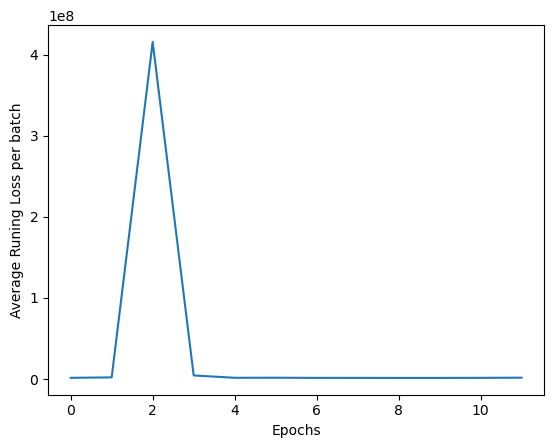

In [52]:
epoch_arr = np.arange(0, len(avg_loss_arr))
loss_arr = np.array(avg_loss_arr)
plt.plot(avg_loss_arr)
plt.xlabel("Epochs")
plt.ylabel("Average Runing Loss per batch")
plt.show()

In [54]:
net.eval()

BallStickNet(
  (fc_layers): ModuleList(
    (0): Linear(in_features=288, out_features=288, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=288, out_features=288, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=288, out_features=288, bias=True)
    (5): ELU(alpha=1.0)
  )
  (encoder): Sequential(
    (0): Linear(in_features=288, out_features=288, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=288, out_features=288, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=288, out_features=288, bias=True)
    (5): ELU(alpha=1.0)
    (6): Linear(in_features=288, out_features=6, bias=True)
  )
)

In [16]:
torch.save(final_model, 'model_100206_not_converge.pt')

In [55]:
X_pred_train, mu_cart_pred_train, lambda_par_pred_train, lambda_iso_pred_train,  volume_0_pred_train, volume_1_pred_train, s0_pred_train = net(torch.from_numpy(scan_100206_long_no_background.astype(np.float32)))

In [56]:
X_pred_train.shape

torch.Size([935442, 288])

In [60]:
# Load model

# net_test = BallStickNet(gradient_directions, b_values)
# net_test.load_state_dict(torch.load('model_100206_61e.pt'))
# net_test.eval()
# X_pred_test, mu_cart_pred_test, lambda_par_pred_test, lambda_iso_pred_test,  volume_0_pred_test, volume_1_pred_test, s0_pred_test = net_test(torch.from_numpy(normalized_scan_100206.astype(np.float32)))

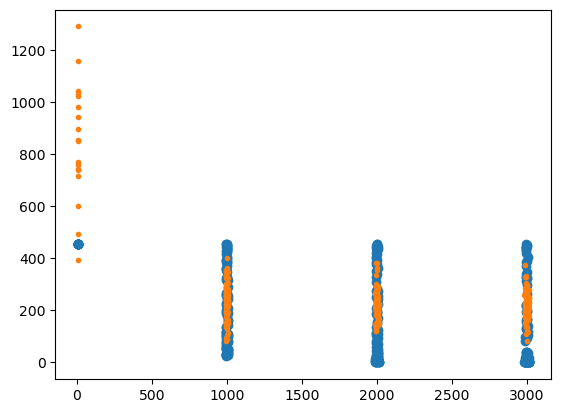

In [73]:
plt.plot(bvals*1e03, X_pred_train[200,:].detach().numpy(),  "o")
# plt.plot(X_pred_train[110,:].detach().numpy())
plt.plot(bvals*1e03,scan_100206_long_no_background[200,:], ".")

In [70]:
b5_indices = np.where(bvals==0.005)

In [72]:
X_pred_train.detach().numpy()[2,b5_indices]

array([[363.97882, 363.975  , 363.9713 , 363.97144, 363.9675 , 363.9634 ,
        363.95895, 363.9608 , 363.95813, 363.96402, 363.9654 , 363.9675 ,
        363.95645, 363.95972, 363.96298, 363.96228, 363.96536, 363.96878]],
      dtype=float32)

In [65]:
X_pred_train[2,0]

tensor(363.9788, grad_fn=<SelectBackward0>)

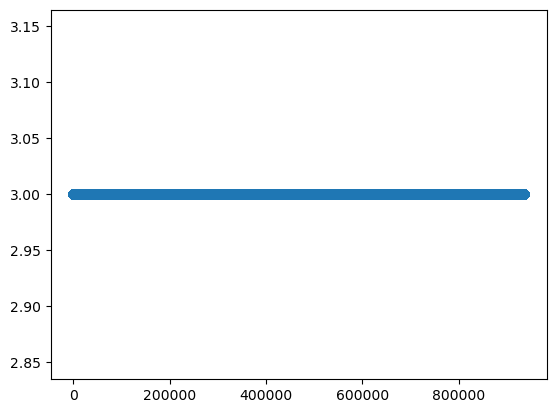

In [61]:
plt.plot(lambda_par_pred_train.detach().numpy(), 'o')

In [21]:
torch.min(lambda_par_pred_train)

tensor(0.1000, grad_fn=<MinBackward1>)

In [22]:
torch.max(lambda_par_pred_train)

tensor(3., grad_fn=<MaxBackward1>)

## Parameter maps

In [105]:
print(X_pred_train.shape)
print(normalized_scan_100206.shape)

torch.Size([935442, 288])
(935442, 288)


In [108]:
lambda_par_pred_train.shape

torch.Size([935442, 1])

In [127]:
mask_100206_long_pro.shape

(3658350, 1)

In [111]:
scan_100206_long.shape

(3658350, 288)

In [115]:
bg_indices = np.where(mask_100206_long_pro == 0)[0]

In [121]:
lambda_par_pred_train_cp = np.copy(lambda_par_pred_train.detach().numpy())

In [ ]:
def replace_ones(mask_100206, params):
    mask_100206_cp = np.copy(mask_100206)
    bg_indices = np.where(mask_100206_cp == 1)[0]
    for i, index in enumerate(bg_indices):
        mask_100206_cp[index] = params[i]
    return mask_100206_cp